# MoA(Mixture of Agents) Search

- Author: [Kane](https://github.com/HarryKane11)
- Design:
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/02-RecommendationSystem/03-ResumeRecommendationReview.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/02-RecommendationSystem/03-ResumeRecommendationReview.ipynb)

## Overview

This code implements a sophisticated Multi-Model Search and Analysis System designed to provide comprehensive answers to user queries through a distributed search and analysis workflow.
The system architecture consists of three main components:

- Query Generation and Search
  - The system generates multiple search queries from the user's question using GPT-4o, ensuring comprehensive coverage of the topic. These queries are then executed in parallel using the Tavily Search API for efficient information gathering.
- Multi-Model Analysis
  - The aggregated search results are processed independently by three different language models (GPT-4o Mini, Claude Haiku, and Gemini 1.5 Flash 8B). Each model provides its unique perspective and analysis, complete with citations to source materials.
- Result Synthesis
- The system collects analyses from all models and synthesizes them using GPT-4o, producing a comprehensive response that incorporates diverse viewpoints while maintaining citation accuracy.

**Key Features**:

- Parallel Processing: Implements a map-reduce pattern for efficient search execution and analysis distribution across multiple models.
- Multi-Model Architecture: Leverages three distinct AI models to analyze search results from different perspectives, ensuring a balanced and thorough analysis.
- Dynamic Workflow: Built on LangGraph's state management system, enabling real-time result streaming and flexible execution paths while maintaining robust state management throughout the process.

This system is particularly effective for complex queries requiring comprehensive information gathering and analysis, leveraging the strengths of multiple AI models to provide thorough and balanced responses.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [State and Models Setup](#state-and-models-setup)
- [Query Generation](#query-generation)
- [Search Task Creation](#search-task-creation)
- [Aggregating Search Results](#aggregating-search-results)
- [Analysis Task Creation](#analysis-task-creation)
- [Model Analysis](#model-analysis)
- [Synthesizing Results](#synthesizing-results)
- [Helper Functions and Execution](#helper-functions-and-execution)

### References

- [Genspark - Enhancements in Mixture of Agents](https://www.genspark.ai/spark/enhancements-in-mixture-of-agents/073b2415-5101-42b0-abe4-59f62410c8f0)
- [Langgraph - Map & Reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)
- [Tavily](https://tavily.com/)
---

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [76]:
%%capture --no-stderr
%pip install langchain-opentutorial


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain-community",
        "langchain-openai",
        "langchain-anthropic",
        "langchain-google-genai",
        "langgraph"
    ],
    verbose=False,
    upgrade=False,
)

In [27]:
# Set environment variables

from langchain_opentutorial import set_env

set_env(
    {
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "07-Agent",
        "OPENAI_API_KEY":"",
        "ANTHROPIC_API_KEY":"",
        "GOOGLE_API_KEY":""
    }
)

Environment variables have been set successfully.


In [28]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [29]:
# Imports for required libraries and modules
import operator
from typing import Annotated, List, Sequence, Dict
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langgraph.constants import Send

# Utility function to merge dictionaries
def dict_merge(old_dict: dict, new_dict: dict) -> dict:
    """Reducer function for merging dictionaries."""
    if not old_dict:
        return new_dict
    if not new_dict:
        return old_dict
    return {**old_dict, **new_dict}

## State and Models Setup
This section defines the `AgentState` structure for managing the workflow's state, 
along with the `SearchQueries` model for query generation. It also sets up the search tool 
and initializes multiple models with different characteristics.

In [30]:
# Define the agent's state using a TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # Message history
    search_queries: List[str]  # List of generated search queries
    raw_search_results: Annotated[Dict, dict_merge]  # Merged search results
    aggregated_search_results: str  # Combined search results as a single document
    model_responses: Annotated[Dict, dict_merge]  # Responses from different models
    final_answer: str  # Synthesized final answer

# Define a Pydantic model for search queries
class SearchQueries(BaseModel):
    queries: List[str] = Field(description="List of search queries")

# Set up the search tool
search_tool = TavilySearchResults(max_results=3)

# Configure multiple models with different characteristics
models = {
    "gpt-4o-mini": ChatOpenAI(model="gpt-4o-mini"),  # OpenAI GPT-4
    "claude-haiku": ChatAnthropic(model="claude-3-5-haiku-20241022"),  # Anthropic Claude
    "gemini-1.5-flash": ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b")  # Google's Gemini
}

## Query Generation
This section defines a prompt template and combines it with a model to generate 3-5 
search queries that cover different aspects of the user's question.

In [31]:
# Define a prompt template for generating search queries
query_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", """Generate 3-5 different search queries to find comprehensive information about the user's question.
    Each query should focus on a different aspect or use different search terms to ensure broad coverage."""),
    ("human", "{question}")
])

# Combine the prompt with a model to generate queries
query_generator = query_gen_prompt | ChatOpenAI(model="gpt-4o").with_structured_output(SearchQueries)

# Async function to generate queries based on the latest user message
async def generate_queries(state: AgentState) -> dict:
    """Generate search queries."""
    question = state["messages"][-1].content  # Get the latest user message
    result = await query_generator.ainvoke({"question": question})  # Generate queries
    print(f"Generated queries: {result.queries}")
    return {"search_queries": result.queries}  # Return the list of generated queries

In [32]:
search_queries=query_generator.invoke("Is tesla's business strategy valid?")
search_queries

SearchQueries(queries=['Tesla business strategy analysis 2023', 'Tesla competitive advantage and business model', 'Tesla SWOT analysis latest', 'Tesla market strategy and future plans', 'Tesla growth strategy and sustainability'])

## Search Task Creation
This section creates tasks using `Send` objects for executing search queries in parallel. 
Each query will be processed independently.

In [59]:
# Function to create tasks for parallel search execution
def create_search_tasks(state: AgentState):
    """Create Send objects for parallel search processing."""
    return [
        Send("search_executor", {"query": query})  # Task for each search query
        for query in state["search_queries"]  # Iterate over all generated queries
    ]

# Async function to execute a single search
async def search_executor(state: dict) -> dict:
    """Execute individual search queries."""
    try:
        query = state["query"]  # Extract the query from the state
        print(f"Searching for: {query}")
        search_results = await search_tool.ainvoke(query)  # Use the search tool to get results
        return {"raw_search_results": {query: search_results}}  # Return search results
    except Exception as e:
        print(f"Search error for query '{query}': {str(e)}")
        return {"raw_search_results": {}}  # Return empty results in case of an error

In [60]:
create_search_tasks({"search_queries":search_queries})

[Send(node='search_executor', arg={'query': ('queries', ['Tesla business strategy analysis 2023', 'Tesla competitive advantage and business model', 'Tesla SWOT analysis latest', 'Tesla market strategy and future plans', 'Tesla growth strategy and sustainability'])})]

## Aggregating Search Results
This section combines raw search results from multiple queries into a single, 
structured document for easier analysis.

In [69]:
# Async function to aggregate raw search results into a single document
async def aggregate_search_results(state: AgentState) -> dict:
    """Combine multiple search results into a single document."""
    all_results = state.get("raw_search_results", {})  # Retrieve raw search results

    # Create a structured document from all search results
    aggregated_document = []
    for query, results in all_results.items():
        aggregated_document.append(f"\n### Search Results for Query: '{query}'\n")
        for idx, result in enumerate(results, 1):
            aggregated_document.append(f"[{idx}] Content: {result['content']}")
            aggregated_document.append(f"    Source: {result['url']}\n")
    
    aggregated_text = "\n".join(aggregated_document)
    return {"aggregated_search_results": aggregated_text}

## Analysis Task Creation
This section creates tasks for analyzing the aggregated search results using different models. 
Each model processes the results independently.

In [78]:
# Function to create analysis tasks for each model
def create_analysis_tasks(state: AgentState):
    """Create tasks for analyzing the aggregated search results with each model."""
    combined_results = state.get("aggregated_search_results", "")  # Get combined search results
    original_question = state["messages"][0].content
    return [
        Send("model_analyzer", {
            "model_name": model_name,  # Specify the model name
            "search_results": combined_results,  # Provide the combined results
            "question": original_question
        })
        for model_name in models.keys()  # Iterate over all available models
    ]

## Model Analysis
A parallel processing stage where each AI model independently analyzes the aggregated search results.

**Key Components**:
1. **Input**: Combined search results and original question
2. **Analysis Process**: Each model (gpt-4o-mini, claude-3-5-haiku-20241022, gemini-1.5-flash-8b) performs:
   - Comprehensive review of search results
   - Fact extraction with citations
   - Response formulation based on source material
3. **Output**: Structured analysis from each model, maintaining citation integrity

The goal is to leverage each model's unique strengths in comprehension and analysis while ensuring traceability back to source materials.

In [79]:
# Async function to analyze search results using a specific model
async def model_analyzer(state: dict) -> dict:
    """Perform analysis of search results with an individual model."""
    try:
        model_name = state["model_name"]
        search_results = state["search_results"]
        question = state["question"]
        
        analysis_prompt = f"""Original Question: {question}
        Search Results:
        {search_results}

        Please provide a comprehensive answer to the original question based on these search results.
        Requirements:
        1. Answer the question accurately using the provided search results
        2. Use citation numbers [1], [2], etc. when referencing specific information
        3. Be clear and concise while maintaining accuracy
        4. If different sources provide conflicting information, acknowledge this and explain

        Format your answer as follows:
        1. Main answer with citations
        2. Additional relevant context (if any)
        3. Any limitations or uncertainties in the available information
        """
        
        model = models[model_name]
        response = await model.ainvoke([HumanMessage(content=analysis_prompt)])
        return {"model_responses": {model_name: response.content}}
    
    except Exception as e:
        print(f"Analysis error for model {model_name}: {str(e)}")
        return {"model_responses": {model_name: "Analysis failed"}}


## Synthesizing Results
The final stage of our multi-model analysis pipeline, combining diverse AI perspectives into a single coherent response.

**Key Components**:
1. **Input**: Original question, model responses, and search results
2. **Synthesis Prompt**: Structures the final response to include:
   - Main analysis with citations
   - Common findings across models
   - Unique insights from each model
   - Source references
3. **Output**: Comprehensive, well-cited answer that directly addresses the user's query

The goal is to provide a balanced perspective that leverages the strengths of each AI model while maintaining clarity and accuracy.

In [80]:
# Async function to synthesize responses from all models into a final answer
async def synthesize_results(state: AgentState) -> dict:
    """Combine analyses from all models into a single, comprehensive answer."""
    original_question = state["messages"][0].content
    model_responses = state["model_responses"]
    search_results = state["aggregated_search_results"]

    # Define a prompt for synthesizing the final answer
    synthesis_prompt = f"""Task: Synthesize multiple AI models' analyses into a single, coherent response.

    Original Question: {original_question}

    Different AI Models' Analyses:
    {model_responses}

    Original Search Results for Reference:
    {search_results}

    Please create a final response that:
    1. Synthesizes the key points where models agree
    2. Acknowledges any differences in models' interpretations
    3. Maintains accurate citations throughout
    4. Provides a unified, coherent answer that best serves the user's question

    Structure your response as follows:
    1. Main Answer (with citations)
    2. Points of Agreement Between Models
    3. Notable Differences or Additional Insights (if any)
    4. Sources Used (list of all cited URLs)
    """
    synthesizer = ChatOpenAI(model="gpt-4o", temperature=0)  # Use GPT-4 for synthesis
    final_response = await synthesizer.ainvoke([HumanMessage(content=synthesis_prompt)])  # Generate the final response
    
    # Return the final synthesized answer
    return {
        "final_answer": final_response.content,
        "messages": [AIMessage(content=final_response.content)]  # Add the response to message history
    }


In [81]:
workflow = StateGraph(AgentState)

# 노드 추가
workflow.add_node("query_generator", generate_queries)
workflow.add_node("search_executor", search_executor)
workflow.add_node("aggregate_results", aggregate_search_results)  # 새로운 노드
workflow.add_node("model_analyzer", model_analyzer)
workflow.add_node("synthesizer", synthesize_results)

# 엣지 추가
workflow.add_edge(START, "query_generator")
workflow.add_conditional_edges(
    "query_generator",
    create_search_tasks,
    {"search_executor": "search_executor"}
)
workflow.add_edge("search_executor", "aggregate_results")
workflow.add_conditional_edges(
    "aggregate_results", 
    create_analysis_tasks,
    {"model_analyzer": "model_analyzer"}
)
workflow.add_edge("model_analyzer", "synthesizer")
workflow.add_edge("synthesizer", END)
app=workflow.compile()

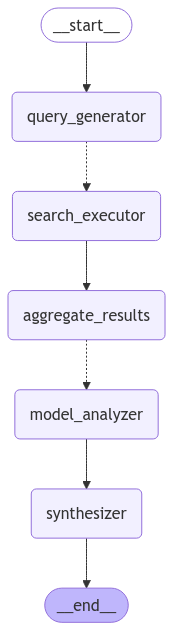

In [82]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [83]:
import nest_asyncio
nest_asyncio.apply()

## Helper Functions and Execution
Functions to manage output display and execute the analysis pipeline with clear progress tracking.

**Key Components**:
1. Progress Tracking (`print_progress`):
   - Visual progress indicators for each pipeline stage
   - Emoji-based status updates for better readability
   - Clear tracking of query generation, search execution, and model analyses
2. Result Display (`display_final_result`):
   - Markdown formatting for the final analysis
   - Structured presentation of synthesized results
   - Clean citation and source reference display

**Pipeline Execution**
The execution process streams results in real-time, providing visibility into each stage of the analysis while maintaining the final result for formatted display.

This approach ensures both transparency during processing and a professionally formatted final output.

In [89]:
from IPython.display import Markdown, display

def print_progress(event: dict):
    """Print workflow progress in a visually appealing format"""
    if "query_generator" in event:
        print("\n🔍 Generated Search Queries:")
        for query in event["query_generator"]["search_queries"]:
            print(f"  • {query}")
    
    elif "search_executor" in event:
        query = list(event["search_executor"]["raw_search_results"].keys())[0]
        print(f"\n🔎 Completed search for: {query}")
    
    elif "aggregate_results" in event:
        print("\n📑 Search results aggregated and formatted")
    
    elif "model_analyzer" in event:
        model_name = list(event["model_analyzer"]["model_responses"].keys())[0]
        print(f"\n🤖 Analysis from {model_name} completed")
    
    elif "synthesizer" in event:
        print("\n✨ Final synthesized answer generated")


def display_final_result(final_response: str):
    """Display final result in markdown format"""
    markdown_text = f"""
    # Analysis Results

    ## Final Answer
    {final_response}
    """
    display(Markdown(markdown_text))


In [90]:
# write question here
question = "Analyze Tesla's Q1 2025 Business Strategy Status and Outlook"
inputs = {
    "messages": [HumanMessage(content=question)]
}

# Execution code
final_result = None
async for event in app.astream(inputs):
    print_progress(event)
    if "synthesizer" in event:
        final_result = event["synthesizer"]["final_answer"]

if final_result:
    display_final_result(final_result)

Generated queries: ['Tesla Q1 2025 business strategy analysis', 'Tesla 2025 first quarter financial performance and outlook', 'Tesla strategic initiatives Q1 2025', 'Tesla business growth and challenges Q1 2025', 'Tesla Q1 2025 market expansion and innovation plans']

🔍 Generated Search Queries:
  • Tesla Q1 2025 business strategy analysis
  • Tesla 2025 first quarter financial performance and outlook
  • Tesla strategic initiatives Q1 2025
  • Tesla business growth and challenges Q1 2025
  • Tesla Q1 2025 market expansion and innovation plans
Searching for: Tesla Q1 2025 business strategy analysis
Searching for: Tesla 2025 first quarter financial performance and outlook
Searching for: Tesla strategic initiatives Q1 2025
Searching for: Tesla business growth and challenges Q1 2025
Searching for: Tesla Q1 2025 market expansion and innovation plans

🔎 Completed search for: Tesla 2025 first quarter financial performance and outlook

🔎 Completed search for: Tesla business growth and challen


# Analysis Results

## Final Answer
### Main Answer

As of Q1 2025, Tesla's business strategy is focused on expanding its market presence through several key initiatives. A major component of this strategy is the planned launch of an affordable electric vehicle (EV) priced at approximately $25,000. This initiative aims to broaden Tesla's customer base and increase vehicle sales volume significantly [1][2][3]. Tesla is also targeting an annual production capacity of 100 GWh by the end of fiscal year 2025, with energy deployments already reaching 31.4 GWh in fiscal year 2024 [1][3]. 

In addition to vehicle affordability, Tesla is emphasizing cost reductions and advancements in artificial intelligence (AI) and autonomous vehicle (AV) technologies. The company is exploring new revenue streams through innovations such as robotaxis and Optimus robots, reflecting a broader vision for sustainable automotive solutions [1][2][3]. Financially, Tesla has reported strong earnings and forecasts up to 30% growth in vehicle sales for the year, supported by the success of the Cybertruck and declining material costs [1][2].

### Points of Agreement Between Models

1. **Affordable EV Launch**: All models agree that Tesla's strategy includes launching a $25,000 EV to expand its market reach and increase sales volume [1][2][3].
   
2. **Production and Capacity Goals**: There is consensus on Tesla's target of achieving 100 GWh in annual production by FY25, with significant energy deployments already underway [1][3].

3. **Focus on AI and AV Technologies**: The models highlight Tesla's strategic focus on expanding its AI and AV capabilities, including the development of robotaxis and Optimus robots [1][2][3].

4. **Financial Outlook**: All models note Tesla's optimistic financial outlook, with predictions of 20-30% growth in vehicle sales for 2025, contingent on the successful introduction of the lower-cost vehicle [1][2].

### Notable Differences or Additional Insights

- **Stock Valuation Concerns**: Some models, such as 'gpt-4o-mini' and 'claude-haiku', mention concerns about Tesla's stock valuation potentially being disconnected from its business fundamentals, attributing a premium to Elon Musk's leadership [3]. This aspect is less emphasized in 'gemini-1.5-flash'.

- **Market Expansion**: While all models discuss Tesla's market expansion efforts, 'claude-haiku' specifically highlights the competitive landscape with other EV manufacturers like BYD and Volkswagen, which adds an element of uncertainty to Tesla's growth strategy [1].

### Sources Used

1. [Seeking Alpha](https://seekingalpha.com/article/4749379-how-tesla-plans-to-lead-in-2025)
2. [Morningstar](https://www.morningstar.com/company-reports/1258674-teslas-strategic-focus-shifts-to-development-of-affordable-vehicles-cost-reductions-and-ai)
3. [Investing.com](https://www.investing.com/news/stock-market-news/three-themes-to-shape-teslas-outlook-in-2025-says-barclays-3813602)
    